# **Spaceship Titanic**

## **Librerías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = False

In [3]:
from datetime import datetime, timedelta
import winsound

In [84]:
import sys
import warnings

In [5]:
sys.path.append('C:/Users/jmart/OneDrive/Documentos/Proyectos/Proyectos_Web/Utils')

In [85]:
warnings.filterwarnings("ignore")

In [6]:
from sklearn.model_selection import train_test_split

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [128]:
from sklearn.tree import DecisionTreeClassifier

In [65]:
import xgboost as xgb

C:\Users\jmart\anaconda3\envs\StarterPack\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [126]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

## **Datos**

In [8]:
train_df = pd.read_csv('./Datos/train.csv')

In [9]:
train_df.sample()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
4847,5173_01,Mars,True,F/1057/P,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,Supies Biba,True


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [11]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### **Limpieza y Preparación de Datos**

In [12]:
# Planeta natal
train_df['HomePlanet'].fillna('Unknown', inplace=True)
train_df.value_counts(['HomePlanet'])

HomePlanet
Earth         4602
Europa        2131
Mars          1759
Unknown        201
dtype: int64

In [13]:
# Sueño criogenico
train_df['CryoSleep'].fillna('Unknown', inplace=True)
train_df.value_counts(['CryoSleep'])

CryoSleep
False        5439
True         3037
Unknown       217
dtype: int64

In [14]:
def calc_detail_cabin(x, position):
	# Divides la cadena en subcadenas utilizando '/' como separador y devuelve el primer elemento
	try:
		return x.split('/')[position]        
	# Si ocurre algún error al intentar dividir la cadena, se devuelve la cadena original
	except:
		return x

In [15]:
# Información de la cabina
train_df['Cabin'].fillna('Unknown', inplace=True)
train_df['Cabin_Type'] = train_df['Cabin'].apply(lambda x: calc_detail_cabin(x, 0))
train_df['Cabin_Type_2'] = train_df['Cabin'].apply(lambda x: calc_detail_cabin(x, 2))

In [16]:
train_df.value_counts(['Cabin_Type'])

Cabin_Type
F             2794
G             2559
E              876
B              779
C              747
D              478
A              256
Unknown        199
T                5
dtype: int64

In [17]:
train_df.value_counts(['Cabin_Type_2'])

Cabin_Type_2
S               4288
P               4206
Unknown          199
dtype: int64

In [18]:
# Destino
train_df['Destination'].fillna('Unknown', inplace=True)
train_df.value_counts(['Destination'])

Destination  
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Unknown           182
dtype: int64

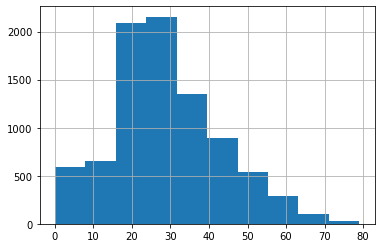

In [19]:
#Edad
train_df['Age'].fillna(round(train_df['Age'].mean()), inplace=True)
train_df['Age'].hist()
plt.show()

In [20]:
# VIP
train_df['VIP'].fillna('Unknown', inplace=True)
train_df.value_counts(['VIP'])

VIP    
False      8291
Unknown     203
True        199
dtype: int64

In [21]:
# Variables numéricas $$
train_df['RoomService'].fillna(0, inplace=True)
train_df['FoodCourt'].fillna(0, inplace=True)
train_df['ShoppingMall'].fillna(0, inplace=True)
train_df['Spa'].fillna(0, inplace=True)
train_df['VRDeck'].fillna(0, inplace=True)

In [22]:
# Eliminamos el nombre
train_df.drop('Name', axis= 1, inplace=True)

In [23]:
train_df['Transported'].replace([False, True], [0, 1], inplace=True)

### **Preparando los datos para el modelo**

In [24]:
train_df['CryoSleep'].replace([False, True, 'Unknown'], [0, 1, 0], inplace=True)
train_df['VIP'].replace([False, True, 'Unknown'], [0, 1, 0], inplace=True)

In [25]:
home_planet_dum = pd.get_dummies(train_df['HomePlanet'])
destination_dum = pd.get_dummies(train_df['Destination'])
cabin_I_dum = pd.get_dummies(train_df['Cabin_Type'])
cabin_II_dum = pd.get_dummies(train_df['Cabin_Type_2'])

In [26]:
X = train_df.drop(
    ['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Cabin_Type', 'Cabin_Type_2'], 
    axis=1
)

In [27]:
X = pd.merge(X.reset_index(), home_planet_dum.reset_index(), how='left', left_on='index', right_on='index')
X = pd.merge(X, destination_dum.reset_index(), how='left', left_on='index', right_on='index')
X = pd.merge(X, cabin_I_dum.reset_index(), how='left', left_on='index', right_on='index')
X = pd.merge(X, cabin_II_dum.reset_index(), how='left', left_on='index', right_on='index')

C:\Users\jmart\AppData\Local\Temp\ipykernel_19836\1860298275.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unknown_x'} in the result is deprecated and will raise a MergeError in a future version.
  X = pd.merge(X, cabin_II_dum.reset_index(), how='left', left_on='index', right_on='index')


In [28]:
X.drop(['index', 'Unknown_x', 'Unknown_y', 'Unknown_x', 'Unknown_y', 'Transported'], axis=1, inplace=True)

## **Modelo**

In [91]:
train_df['Transported'].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

In [92]:
y = train_df['Transported']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, train_size=0.8)

### **1. Random Forest**

In [94]:
random_forest = RandomForestClassifier(random_state=13)

In [95]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=13)

In [96]:
y_pred = random_forest.predict(X_test)

In [97]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       921
           1       0.76      0.80      0.78       818

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



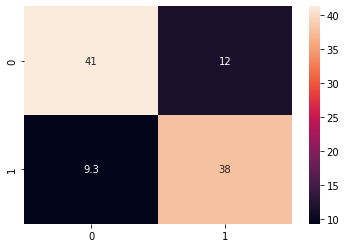

In [98]:
sns.heatmap((confusion_matrix(y_pred, y_test)/len(X_test))*100, annot=True)
plt.show()

In [99]:
feature_importance = random_forest.feature_importances_
feature_names=X.columns
dic_feature_importance = {
                        'feature_importance':feature_importance ,
                        'feature_names':feature_names }
feature_importance_DF= pd.DataFrame(dic_feature_importance).sort_values(by='feature_importance',ascending=False)
feature_importance_DF.head(5)

,feature_importance,feature_names
1,0.176832,Age
6,0.127403,Spa
3,0.121280,RoomService
7,0.111661,VRDeck
4,0.101729,FoodCourt


#### **Grid Search**

In [100]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [7, 9, 11],
    'min_samples_split': [2, 3, 4, 5]
}

In [101]:
rf_model = RandomForestClassifier()

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3)

In [102]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 9, 11],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [107]:
y_pred_gs = grid_search_rf.predict(X_test)

In [108]:
print(classification_report(y_pred_gs, y_test))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       848
           1       0.82      0.79      0.80       891

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



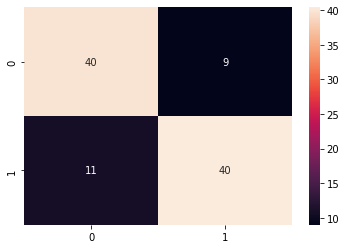

In [110]:
sns.heatmap((confusion_matrix(y_pred_gs, y_test)/len(X_test))*100, annot=True)
plt.show()

In [111]:
print("Mejor conjunto de parámetros: ", grid_search_rf.best_params_)
print("Mejor puntaje: ", grid_search_rf.best_score_)

Mejor conjunto de parámetros:  {'max_depth': 9, 'min_samples_split': 5, 'n_estimators': 300}
Mejor puntaje:  0.8004026459591601


### **2. XGBoost**

In [112]:
xgb_model = xgb.XGBClassifier()

In [113]:
xgb_model.fit(X_train, y_train)

[21:57:38] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [114]:
y_pred_xgb = xgb_model.predict(X_test)

In [115]:
print(classification_report(y_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       852
           1       0.81      0.78      0.79       887

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



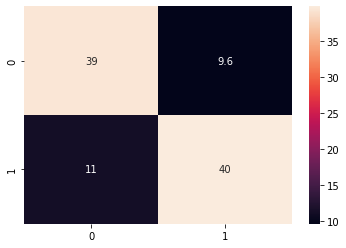

In [116]:
sns.heatmap((confusion_matrix(y_pred_xgb, y_test)/len(X_test))*100, annot=True)
plt.show()

In [117]:
feature_importance = xgb_model.feature_importances_
feature_names=X.columns
dic_feature_importance = {
                        'feature_importance':feature_importance ,
                        'feature_names':feature_names }
feature_importance_DF= pd.DataFrame(dic_feature_importance).sort_values(by='feature_importance',ascending=False)
feature_importance_DF.head(5)

,feature_importance,feature_names
0,0.482335,CryoSleep
8,0.136177,Earth
9,0.056408,Europa
18,0.040587,E
10,0.025851,Mars


#### **Grid Search**

In [118]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': [7, 9, 11],
    'n_estimators': [100, 200, 300]
}

In [119]:
xgb_model_gs = xgb.XGBClassifier()

In [120]:
grid_search_xgb = GridSearchCV(xgb_model_gs, param_grid, cv=3)

In [121]:
grid_search_xgb.fit(X_train, y_train)

[21:58:41] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:58:41] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:58:42] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:58:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [122]:
print("Mejor conjunto de parámetros: ", grid_search_xgb.best_params_)
print("Mejor puntaje: ", grid_search_xgb.best_score_)

Mejor conjunto de parámetros:  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}
Mejor puntaje:  0.7976704055220017


In [123]:
y_pred_xgb_gs = grid_search_xgb.predict(X_test)

In [124]:
print(classification_report(y_pred_xgb_gs, y_test))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       836
           1       0.81      0.77      0.79       903

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



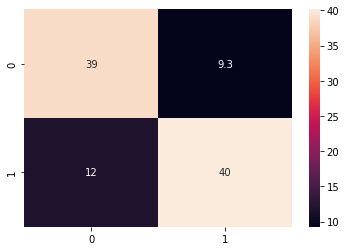

In [125]:
sns.heatmap((confusion_matrix(y_pred_xgb_gs, y_test)/len(X_test))*100, annot=True)
plt.show()

### **3. Bagging**

In [129]:
decision_tree = DecisionTreeClassifier()

In [136]:
bagging = BaggingClassifier(base_estimator=grid_search_rf, n_estimators=100, random_state=0)

In [ ]:
bagging.fit(X_train, y_train)

In [ ]:
y_pred_bagg = bagging.predict(X_test)

In [ ]:
print(classification_report(y_pred_bagg, y_test))

In [ ]:
sns.heatmap((confusion_matrix(y_pred_bagg, y_test)/len(X_test))*100, annot=True)
plt.show()